## CHALLENGE 1
------------------------

I've decided to work on this particular dataset because I want to explore how to work on unbalanced data, a situation that can easily happen in real-life cases (the most famous cases are for breast cancer recognition and, as shown in this notebook, fraud detaction). 

The Kaggle dataset I'm using contains 284807 transactions, and 492 of them (0.017%) are classified as frauds. There are no Null values, so we don't have to work on ways to replace them, and all the variables used have been scaled and anonymised for privacy reasons (except for Amount and Time).
I will try to use Logistic Regression for correctly predicting whether a transaction is fraudulent or not, using two different approaches:

1- Undersampling: I will randomly extract a sample of data with a 50:50 ratio between frauds and normal and train the model on this subsample. It's an approach that involves a big loss of information (we will have 492 non-frauds rows instead of 284315) 

2- Oversampling: using SMOTE, a technique that populates the dataset with new syntethic points, balancing the ratio.

As a model, I decided to stick with a Logistic Regression for simplicity reasons. In future updates/challenges I'm willing to try out different techniques (such as KNN Classifiers or Random Forests).

Thanks to Janio Bachmann for the help: https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

In [2]:
#importing libraries

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

#model used: Logistic Regression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.under_sampling import NearMiss

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

from sklearn.metrics import plot_confusion_matrix

In [3]:
data_folder = Path("C:/Users/***/Credit Card - Unbalanced")
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.describe(include='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Our dataset doesn't need to be cleaned or preprocessed, but it's important to notice its peculiar characteristic (that's why I've chosen it for the challenge): it's very unbalanced! The frauds are just a small percentage of the dataset (0.017%)!

Shape of the dataset: (284807, 31)


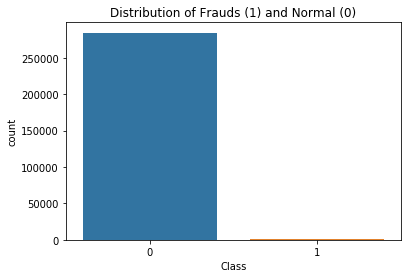

In [5]:
sns.countplot('Class', data=df)
plt.title('Distribution of Frauds (1) and Normal (0)')
print("Shape of the dataset: {}".format(df.shape))

## Preprocessing
I will scale the data with Robustscaler (less impact from outliers). 
Most of the data is already scaled, we only need to work on the variables Amount and Time.

In [6]:
scaler = RobustScaler()

df['amountnew'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['timenew'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

amountnew = df['amountnew']
timenew = df['timenew']

df.drop(['amountnew', 'timenew'], axis=1, inplace=True)
df.insert(0, 'Amount_Scaled', amountnew)
df.insert(1, 'Time_Scaled', timenew)
df.head()

,Amount_Scaled,Time_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## Approach 1: Undersampling. 
Let's extract a sample of the data with a 50:50 ratio between Frauds/no Frauds (which is essentially a concatenation between all the 492 frauds and 492 normal transactions randomly extracted from the shuffled dataset.

With this method, we have a small subset (implying a big information loss!) where we can train the model.

In [7]:
df = df.sample(frac=1)

fdf = df.loc[df['Class'] == 1]
nfdf = df.loc[df['Class'] == 0][:492]

concatdf = pd.concat([fdf, nfdf])

df2 = concatdf.sample(frac=1, random_state=1)
df2.head()

,Amount_Scaled,Time_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
92920,-0.282401,-0.241074,-0.338527,1.120889,1.290122,0.062291,0.016087,-0.988249,0.693377,-0.060923,...,0.097629,-0.267306,-0.706776,-0.016416,0.323273,-0.167466,0.072928,0.244808,0.097694,0
150697,1.047998,0.108413,-12.381048,8.213022,-16.962530,7.116091,-9.772826,-3.666836,-16.147363,2.078706,...,0.537795,0.167703,1.503413,-0.767755,0.371951,-1.415639,-0.517022,-0.434621,0.292721,1
268375,0.251240,0.922109,-5.238808,0.623013,-5.784507,1.678889,-0.364432,-0.477295,-4.276132,-0.695173,...,-0.203270,-0.326140,1.509239,-0.215966,-0.245727,0.893041,0.865758,0.854657,-0.964482,1
15146,-0.184448,-0.683713,-0.944498,0.457077,2.007422,-2.067816,-0.583457,-0.306458,-0.092791,0.179813,...,0.379417,0.298287,0.885374,-0.435911,0.021651,0.598290,-0.163475,0.394224,0.172058,0
60166,0.030462,-0.417110,1.171006,-0.391530,0.458074,-0.721409,-0.970987,-0.875784,-0.242556,0.015499,...,-0.165381,-0.190317,-0.407014,0.005640,0.504160,0.513134,-0.870143,0.053107,0.018709,0


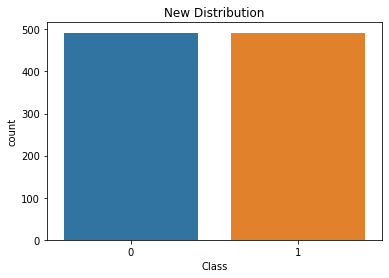

In [8]:
sns.countplot('Class', data=df2)
plt.title('New Distribution')
plt.show()

The undersampled dataset is perfectly balanced (as all things should be)! 

So, let's try to fit a Logistic Regression model on it...

In [9]:
X_sample = df2.drop('Class', axis=1)
y_sample = df2['Class']

X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=1)

X_train_sample = X_train_sample.values
X_test_sample = X_test_sample.values
y_train_sample = y_train_sample.values
y_test_sample = y_test_sample.values

With Gridsearch, the model is automatically selecting the best hyperparameters to use. It's a slow process because all the combinations must be tried, but the sample is very small, thus it takes just a few seconds.

In [10]:
lgparameters = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

gslg = GridSearchCV(LogisticRegression(), lgparameters)
gslg.fit(X_train_sample, y_train_sample)

#best one:
logistic_regression_sample = gslg.best_estimator_

In [11]:
scorelog = cross_val_score(logistic_regression_sample, X_train_sample, y_train_sample, cv=5)
print('Logistic Regression Cross Validation Score: ', round(scorelog.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.28%


93.5 % accuracy! Very nice! 

Let's plot the confusion matrix, a table that shows the amount of True Positives (top-left), False Positives (top-right), False Negatives (bottom-left) and True Negatives (bottom-right). With this method, we can actually see if the system is confusing some classes or it's actually classifying them in the right way.

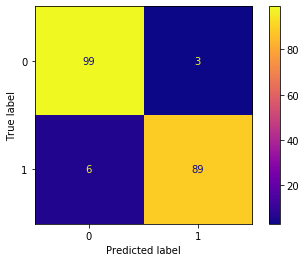

In [12]:
plot_confusion_matrix(logistic_regression_sample, X_test_sample, y_test_sample, cmap='plasma')

The model is working well on the small subset we randomly extracted... 

The next step is to use the trained model with the whole dataset (with 280000 rows) and compare the results.

In [13]:
us_X = df.drop('Class', axis=1)
us_y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(us_X, us_y):
    print("Train:", train_index, "Test:", test_index)
    us_Xtrain, us_Xtest = us_X.iloc[train_index], us_X.iloc[test_index]
    us_ytrain, us_ytest = us_y.iloc[train_index], us_y.iloc[test_index]
    
us_Xtrain = us_Xtrain.values
us_Xtest = us_Xtest.values
us_ytrain = us_ytrain.values
us_ytest = us_ytest.values 

Train: [ 56962  56963  56964 ... 284804 284805 284806] Test: [    0     1     2 ... 56959 56960 56961]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56962  56963  56964 ... 113928 113929 113930]
Train: [     0      1      2 ... 284804 284805 284806] Test: [112686 112768 112816 ... 170887 170888 170889]
Train: [     0      1      2 ... 284804 284805 284806] Test: [169196 169343 169931 ... 227853 227854 227855]
Train: [     0      1      2 ... 227853 227854 227855] Test: [222468 222845 223300 ... 284804 284805 284806]


In [14]:
for train, test in sss.split(us_Xtrain, us_ytrain):
    us_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), logistic_regression_sample) 
    us_model = us_pipeline.fit(us_Xtrain, us_ytrain)
    us_prediction = us_model.predict(us_Xtrain)

In [15]:
print('---' * 40)
print('Train Evaluation of Logistic Regression on undersampled data:\n')
print("Accuracy Score: {:.2f}".format(us_pipeline.score(us_Xtrain, us_ytrain)))
print("Precision Score: {:.2f}".format(precision_score(us_ytrain, us_prediction)))
print("Recall Score: {:.2f}".format(recall_score(us_ytrain, us_prediction)))
print("F1 Score: {:.2f}".format(f1_score(us_ytrain, us_prediction)))
print('---' * 40)

------------------------------------------------------------------------------------------------------------------------
Train Evaluation of Logistic Regression on undersampled data:

Accuracy Score: 0.81
Precision Score: 0.01
Recall Score: 0.91
F1 Score: 0.02
------------------------------------------------------------------------------------------------------------------------


I'm using both Precision Score, Recall Score and F1 in addition to the "classic" Accuracy Score: in this peculiar case, there is the risk that the model will classify everything as "non fraud" and still get a 99% accuracy because the frauds are just a microscopical part of the dataset! We need the other evaluators, capable to actually "show" if the two class are correctly classified

In [16]:
labels = ['No Fraud', 'Fraud']
us_pred = us_model.predict(us_Xtest)
print(classification_report(us_ytest, us_pred, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.81      0.89     56863
       Fraud       0.01      0.93      0.02        98

    accuracy                           0.81     56961
   macro avg       0.50      0.87      0.45     56961
weighted avg       1.00      0.81      0.89     56961



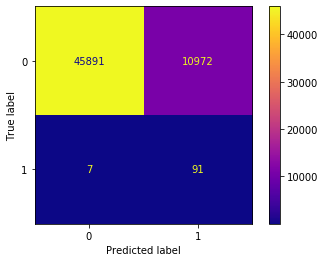

In [17]:
plot_confusion_matrix(us_model, us_Xtest, us_ytest, cmap='plasma')

Unfortunately, the model trained on undersampled data has lost too much information (remember, we went from 480315 to 492 rows of non-frauds!). The Recall is good (it identifies a fraud most of the time, 93% ), but there are thoundands of false alarms that can become a huge problem with real-life customers. 

## Approach 2: Oversampling 

Instead of undersampling, let's see how the model performs with SMOTE, a technique that oversamples the dataset, populating it with new, syntethic data in order to balance the ratio. 

It's likely to be more accurate than the random undersampling, but it takes more computational time than in the previous approach.

In [23]:
log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)
#I'm using the original dataset for the cross validation!

oldX = df.drop('Class', axis=1)
oldy = df['Class']

for train_index, test_index in sss.split(oldX, oldy):
    print("Train:", train_index, "Test:", test_index)
    oldX_train, oldX_test = oldX.iloc[train_index], oldX.iloc[test_index]
    oldy_train, oldy_test = oldy.iloc[train_index], oldy.iloc[test_index]

Train: [ 56962  56963  56964 ... 284804 284805 284806] Test: [    0     1     2 ... 56959 56960 56961]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56962  56963  56964 ... 113928 113929 113930]
Train: [     0      1      2 ... 284804 284805 284806] Test: [112686 112768 112816 ... 170887 170888 170889]
Train: [     0      1      2 ... 284804 284805 284806] Test: [169196 169343 169931 ... 227853 227854 227855]
Train: [     0      1      2 ... 227853 227854 227855] Test: [222468 222845 223300 ... 284804 284805 284806]


In order to search for the best hyperparameters, I used a RandomizedSearch (faster than Gridsearch) for the Logistic Regression. Then, I replicated the same pipeline (with SMOTE and the Logistic Regression)

In [19]:
for train, test in sss.split(oldX_train, oldy_train):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg)
    model = pipeline.fit(oldX_train, oldy_train)
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(oldX_train)

In [20]:
print('---' * 40)
print('Train Evaluation of Logistic Regression on oversampled data with SMOTE:\n')
print("Accuracy Score: {:.2f}".format(pipeline.score(oldX_train, oldy_train)))
print("Precision Score: {:.2f}".format(precision_score(oldy_train, prediction)))
print("Recall Score: {:.2f}".format(recall_score(oldy_train, prediction)))
print("F1 Score: {:.2f}".format(f1_score(oldy_train, prediction)))
print('---' * 40)

------------------------------------------------------------------------------------------------------------------------
Train Evaluation of Logistic Regression on oversampled data with SMOTE:

Accuracy Score: 0.97
Precision Score: 0.06
Recall Score: 0.92
F1 Score: 0.11
------------------------------------------------------------------------------------------------------------------------


In [21]:
labels = ['No Fraud', 'Fraud']
smote_pred = best_est.predict(oldX_test)
print(classification_report(oldy_test, smote_pred, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     56863
       Fraud       0.06      0.95      0.12        98

    accuracy                           0.98     56961
   macro avg       0.53      0.96      0.55     56961
weighted avg       1.00      0.98      0.99     56961



# Comparison

<Figure size 1440x864 with 0 Axes>

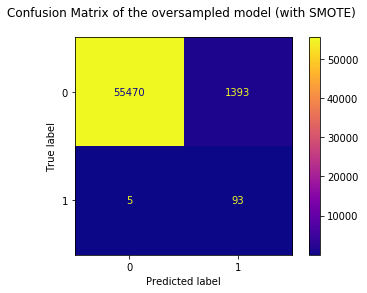

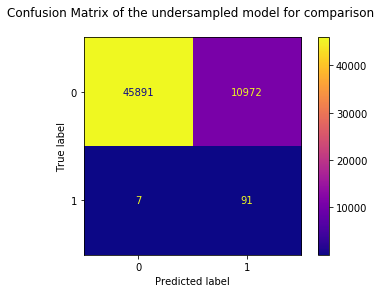

In [22]:
plt.figure(figsize = (20,12))
plot_confusion_matrix(best_est, oldX_test, oldy_test, cmap='plasma')
plt.title('Confusion Matrix of the oversampled model (with SMOTE) \n')
plt.show()  

plot_confusion_matrix(us_model, oldX_test, oldy_test, cmap='plasma')
plt.title('Confusion Matrix of the undersampled model for comparison \n')
plt.show()  


# Conclusions

I think that the best way to compare the two methods is with their respective confusion matrixes: it's evident that SMOTE, despite taking a longer computational time, heavily reduces the amount of false alarms, with a percentage of False Positives near 2.5% and, more importantly, a 95% recall score! This means that the oversampled model is very likely to find frauds (95% of them are identified), and it will send a reasonable amount of false alarms. We should try to improve this result with additional tuning and using different models, but the main objective of this challenge was to obtain a decent score starting from the unbalanced dataset. And that's what happened, thanks to SMOTE.

Thanks for reading!